This is clean implementation of ANN on Concrete dataset using Pipelines 


In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

## Read Dataset and Preprocess

In [30]:
df = pd.read_csv("concrete.csv")
print(df.shape)
df.info()

(1030, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [31]:
df.head(n=4)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [32]:
X = df.drop(columns=["strength"])
y = df["strength"]

print("input shape: ", X.shape)
print("output shape: ", y.shape)

input shape:  (1030, 8)
output shape:  (1030,)


In [33]:
input_features_list = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), input_features_list),
    ],
    remainder="passthrough",
)

In [34]:
pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7
0,0.089726,0.589872,0.000000,0.652556,0.000000,0.496512,0.387607,0.074176
1,0.152740,0.117418,0.621189,0.291534,0.335404,0.813372,0.507275,0.035714
2,0.337900,0.000000,0.478261,0.523962,0.170807,0.453198,0.670346,0.074176
3,0.374429,0.317195,0.000000,0.848243,0.000000,0.380814,0.190667,0.074176
4,0.120548,0.510295,0.000000,0.571086,0.282609,0.716279,0.257652,0.074176


## Build Model and Pipeline

In [35]:
# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=10,              # Stop after 10 epochs without improvement
    restore_best_weights=True
)


def build_model():
    # model = Sequential()
    # model.add(Dense(64, input_dim=8, activation='relu'))  # Assuming input_dim is 8
    # model.add(Dropout(0.3))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(1))  # Output layer for regression
    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=[len(X.keys())]))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer='sgd', 
        loss='mean_squared_error', 
        metrics=["mean_squared_error"]
    )  # Explicit optimizer and loss

    return model

# Use the KerasRegressor from scikeras
model = KerasRegressor(
        model=build_model, 
        epochs=100, 
        batch_size=16, 
        verbose=1,
        callbacks=[early_stop],  # Add early stopping callback
        validation_split=0.2,  # Use 20% of the training data for validation - Needed for val_loss
    )

# Define the pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Scaling input features
    ('model', model)  # Use the KerasRegressor
])

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KerasRegressor(batch_size=16, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x14f6170a0>], epochs=100, model=<function build_model at 0x14f604790>, validation_split=0.2))])

## Split Dataset in Train and Test & Train model on data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape)

# Fit the pipeline (Train model on training dataset)
pipeline.fit(X_train, y_train)

# Evaluate the model on the test dataset
# test_mae = model.score(X_test, y_test)
# print(f"Test MAE: {-test_mae:.2f} units (MPa)")


X_train shape:  (824, 8) y_train shape:  (824,)
X_test shape:  (206, 8) y_test shape:  (206,)
Epoch 1/100


/Users/sumitsontakke/Documents/Dev/PES/mlenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14047175680.0000 - mean_squared_error: 14047175680.0000 - val_loss: 42630136.0000 - val_mean_squared_error: 42630136.0000
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29799408.0000 - mean_squared_error: 29799408.0000 - val_loss: 7819900.0000 - val_mean_squared_error: 7819900.0000
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5457260.5000 - mean_squared_error: 5457260.5000 - val_loss: 1434942.3750 - val_mean_squared_error: 1434942.3750
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 999910.4375 - mean_squared_error: 999910.4375 - val_loss: 264329.7812 - val_mean_squared_error: 264329.7812
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183733.5312 - mean_squared_error: 183733.5312 - val_loss: 48998.6406 - val_mean_squared_error: 48998.6406
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33407.3555 - mean_squared_error: 33407.3555 - val_loss: 9404.1572 - val_mean_squared_error: 9404

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KerasRegressor(batch_size=16, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x14f6170a0>], epochs=100, model=<function build_model at 0x14f604790>, validation_split=0.2))])

In [38]:
# Predict on the test dataset
y_pred = pipeline.predict(X_test)
print("Test predictions generated", y_pred.shape)

print("Evaluation metrics:")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f"R-squared (R²): {r2:.3f}")

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f} MPa")
print(f"RMSE: {rmse:.3f} MPa")
print(f"R²: {r2:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test predictions generated (206,)
Evaluation metrics:
R-squared (R²): -0.000
MAE: 13.770 MPa
RMSE: 16.916 MPa
R²: -0.000


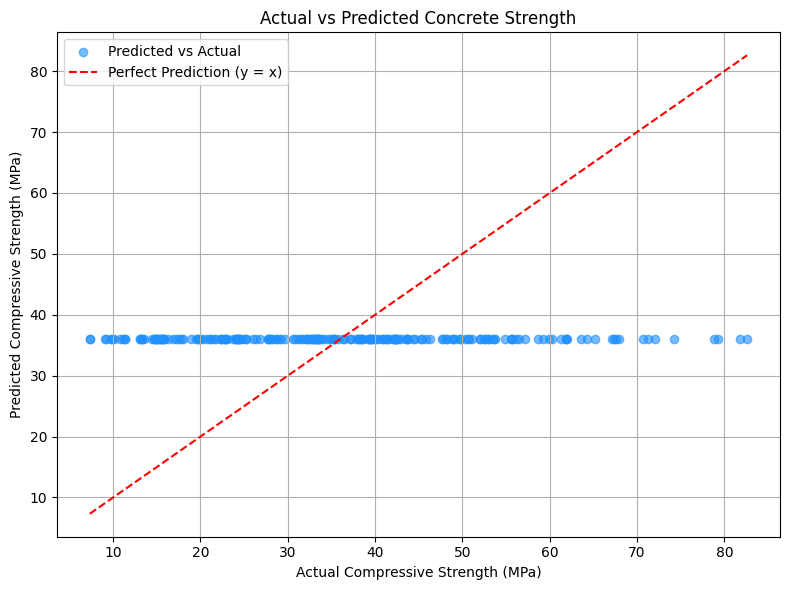

In [39]:
plt.figure(figsize=(8, 6))

# Plot actual vs predicted
plt.scatter(y_test, y_pred, color='dodgerblue', label='Predicted vs Actual', alpha=0.6)

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction (y = x)')

# Add labels, title, legend
plt.xlabel('Actual Compressive Strength (MPa)')
plt.ylabel('Predicted Compressive Strength (MPa)')
plt.title('Actual vs Predicted Concrete Strength')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusion

I've experimented with few ANN layers combinations and found strange outputs. We'll come back to find out why would model spits same value for any input

In [ ]:
    # model = Sequential()
    # model.add(Dense(64, input_dim=8, activation='relu'))  # Assuming input_dim is 8
    # model.add(Dropout(0.3))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(1))  # Output layer for regression
    # model = Sequential()
    # model.add(Dense(30, activation='relu', input_shape=[len(X.keys())]))
    # model.add(Dense(20, activation='relu'))
    # model.add(Dense(20, activation='relu'))
    # model.add(Dense(1, activation='linear'))
